# Etapa 1

## 1.1 Entendimiento del negocio y enfoque analítico

### 1.1.1 Oportunidad/Problema negocio

Categorizar los comentarios de las peliculas en positivos o negativos


### 1.1.2 Enfoque analítico

(Descripción del
requerimiento desde el
punto de vista de
aprendizaje automático)

Uso de tecnicas de aprendizaje automatico(machine learning) y procesamiento de lenguaje natural que tienen como objetivo principal procesar de manera automatica grandes cantidades de texto de los comentarios de las peliculas para poder clasificarlos en positivos o negativos


### 1.1.3 Organización y rol dentro de ella que se beneficia con la oportunidad definida

### 1.1.4 Técnicas y algoritmos a utilizar

a.) Tipo de aprendizaje : supervisado

b.) Tarea de aprendizaje : Clasificación 

c.) Tecnicas de aprendizaje : 

        1. SVM(Máquinas de vectores de soporte)
        2. Regresión logística
        3. Arboles de decisión


## 1.2 Entendimiento y preparación de los datos

### 1.2.1 Carga de los datos

In [77]:
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import contractions
import inflect
import pandas_profiling
import re
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')




nltk.data.path.append(os.path.abspath('./nltk_data'))
nltk.download('punkt', quiet=True, raise_on_error=True, download_dir='./nltk_data')
nltk.download('stopwords', quiet=True, raise_on_error=True, download_dir='./nltk_data')
nltk.download('wordnet', quiet=True, raise_on_error=True, download_dir='./nltk_data')
ROOT_DIR = os.path.abspath(os.curdir)
NLTK_DATA_DIR = os.path.join(ROOT_DIR, 'nltk_data')
nltk.data.path.append(NLTK_DATA_DIR)

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stopwords_spanish = stopwords.words('spanish')
lemmatizer = WordNetLemmatizer()

df_movies = pd.read_csv('./data/MovieReviews.csv',
                        sep=',',
                        encoding='utf-8',
                        index_col=0)

# random_df = df_movies.sample(n=len(df_movies), replace=True)
# random_df.to_csv("./data/randomMovieReviews.csv", index=False)

# df_movies = pd.read_csv('./data/randomMovieReviews.csv',
#                         sep=',',
#                         encoding='utf-8',
#                         index_col=None)º

### 1.2.2 Entendimiento de los datos

In [7]:
df_movies.shape

(5000, 2)

In [8]:
df_movies.head()

,review_es,sentimiento
0,Si está buscando una película de guerra típica...,positivo
1,Supongo que algunos directores de películas de...,positivo
2,Es difícil contarle más sobre esta película si...,positivo
3,"La película comienza muy lentamente, con el es...",positivo
4,Esta película es verdadera acción en su máxima...,positivo


In [9]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_es    5000 non-null   object
 1   sentimiento  5000 non-null   object
dtypes: object(2)
memory usage: 117.2+ KB


In [10]:
# Se calcula el porcentaje de los valores nulos por columna
print((df_movies.isnull().sum()*100 / df_movies.shape[0]).sort_values(ascending=False))

review_es      0.0
sentimiento    0.0
dtype: float64


In [11]:
# Analizar la duplicidad de los datos
df_movies.duplicated().sum()

2

<AxesSubplot:>

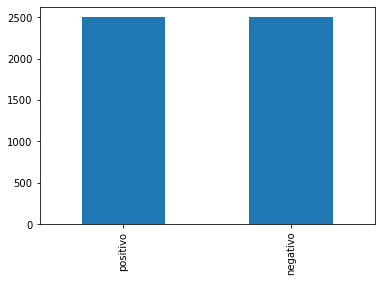

In [12]:
# Analizar distribución de la variable categórica
df_movies['sentimiento'].value_counts().plot(kind='bar')

In [13]:
# Para analizar la columna de review_es vamos a ver los reviews con menos de 30 caracteres
short_reviews = df_movies[df_movies['review_es'].str.len() < 50]
print(short_reviews)

Empty DataFrame
Columns: [review_es, sentimiento]
Index: []


Como puede evidenciarse, no hay filas con reviews cortos o vacíos que se podrían considerar como atípicos.

In [14]:
short_reviews = df_movies[df_movies['review_es'].str.len() < 61]
print(short_reviews)

# El review más corto tiene 61 caracteres, lo cual es un número apropiado.
print(short_reviews['review_es'])

                                              review_es sentimiento
4421  Esta película es terrible pero tiene algunos b...    negativo
4421    Esta película es terrible pero tiene algunos b...
Name: review_es, dtype: object


### 1.2.3 Preparación de los datos

In [15]:
# Se cambian los valores a numéricos
df_movies['sentimiento'] = df_movies['sentimiento'].replace({'positivo': 1, 'negativo': 0})

In [16]:
df_movies.head()

,review_es,sentimiento
0,Si está buscando una película de guerra típica...,1
1,Supongo que algunos directores de películas de...,1
2,Es difícil contarle más sobre esta película si...,1
3,"La película comienza muy lentamente, con el es...",1
4,Esta película es verdadera acción en su máxima...,1


In [17]:
df_movies.dtypes

review_es      object
sentimiento     int64
dtype: object

1    2500
0    2500
Name: sentimiento, dtype: int64


<AxesSubplot:>

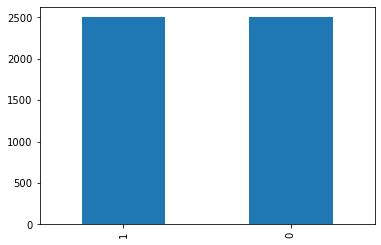

In [18]:
# Analizar distribución de la variable categórica
print(df_movies['sentimiento'].value_counts())
df_movies['sentimiento'].value_counts().plot(kind='bar',)

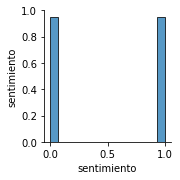

In [19]:
sns.pairplot(df_movies)

Finalmente, se eliminan los valores duplicados, los cuales solo eran 2.

In [20]:
print("Cantidad de datos duplicados: ",df_movies.duplicated().sum())
df_movies.drop_duplicates(inplace=True)
print("Cantidad de datos duplicados después: ",df_movies.duplicated().sum())

df_movies.shape

Cantidad de datos duplicados:  2
Cantidad de datos duplicados después:  0


(4998, 2)

En conclusión, se tienen 4998 filas para crear el modelo.

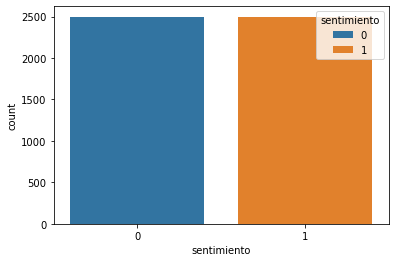

In [21]:
ax = sns.countplot(x="sentimiento", hue="sentimiento", data=df_movies, dodge=False)

In [22]:
df_movies.head(20)

,review_es,sentimiento
0,Si está buscando una película de guerra típica...,1
1,Supongo que algunos directores de películas de...,1
2,Es difícil contarle más sobre esta película si...,1
3,"La película comienza muy lentamente, con el es...",1
4,Esta película es verdadera acción en su máxima...,1
5,Así como un fanático de la vida de las películ...,1
6,"El polvo rojo está bien actuado y bien hecho, ...",1
7,Los talentos de Abbott y Costello brillan en l...,1
8,Asesina sexy Tiffany (Jennifer Tilly) todavía ...,1
9,"Si mis expectativas no se superaron, ciertamen...",1


### 1.2.4 Procesamiento de lenguaje natural

In [23]:

def preprocessor(text):
     text = re.sub('<[^>]*>', '', text)
     emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                            text)
     text = (re.sub('[\W]+', ' ', text.lower()) +
             ' '.join(emoticons).replace('-', ''))
     return text

In [24]:
df_movies['review_es'] = df_movies['review_es'].apply(preprocessor)

In [25]:
df_movies.head(20)

,review_es,sentimiento
0,si está buscando una película de guerra típica...,1
1,supongo que algunos directores de películas de...,1
2,es difícil contarle más sobre esta película si...,1
3,la película comienza muy lentamente con el est...,1
4,esta película es verdadera acción en su máxima...,1
5,así como un fanático de la vida de las películ...,1
6,el polvo rojo está bien actuado y bien hecho p...,1
7,los talentos de abbott y costello brillan en l...,1
8,asesina sexy tiffany jennifer tilly todavía an...,1
9,si mis expectativas no se superaron ciertament...,1


In [26]:

# nltk.download('stopwords')
# stop_words= set(stopwords.words('spanish'))

In [27]:
# Función para tokenizar los tweets
def tokenizer(text):
    tt = TweetTokenizer()
    return tt.tokenize(text)

In [28]:
# El parámetro 'stratify' es útil para asegurar que ambos conjuntos de datos queden aproximadamente balanceados
# Cuando se cuenta con muy pocos datos etiquetados, por lo general se debe disponer de una menor cantidad de datos para evaluación
X_train, X_test, Y_train, Y_test = train_test_split(df_movies['review_es'], df_movies['sentimiento'], test_size = 0.3, stratify = df_movies['sentimiento'], random_state = 1)

In [29]:
X_train.shape

(3498,)

In [30]:
pd.Series(Y_train).value_counts(normalize = True)

1    0.5
0    0.5
Name: sentimiento, dtype: float64

In [31]:
X_test.shape

(1500,)

In [32]:
pd.Series(Y_test).value_counts(normalize = True)

1    0.5
0    0.5
Name: sentimiento, dtype: float64

## Vectorización

In [33]:
bow = CountVectorizer(tokenizer = tokenizer, stop_words = stopwords_spanish, lowercase = True)


In [34]:
X_bow = bow.fit_transform(X_train)

In [35]:
len(bow.vocabulary_)

47097

In [36]:
tfidf=TfidfVectorizer(tokenizer=tokenizer, stop_words=stopwords_spanish, lowercase=True)

In [37]:
X_tfidf = tfidf.fit_transform(X_train)

In [38]:
len(tfidf.vocabulary_)

47097

## 1.3 Modelo y evaluación
Se requiere que llas variables de entrada estén separadas de la variable objetivo.

### 1.3.1 Modelo con Support Vector Machines (SVMs)

#### 1.3.1.1 Construcción del modelo BOW

In [39]:
# Create a svm Classifier
bow_clf = svm.SVC(kernel='linear') # Linear Kernel

# Entrenar el modelo utilizando X_box y Y_train
bow_clf.fit(X_bow, Y_train)

y_train_bow_predict = bow_clf.predict(X_bow)
y_test_bow_predict = bow_clf.predict(bow.transform(X_test))

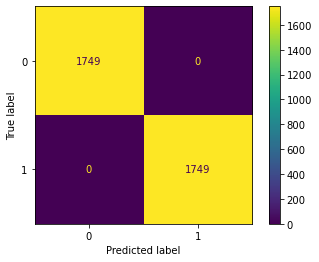

In [40]:
metrics.ConfusionMatrixDisplay.from_predictions(Y_train, y_train_bow_predict)

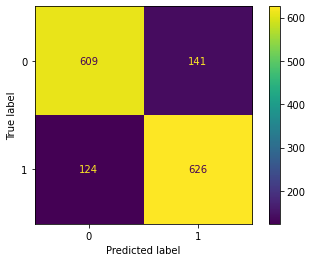

In [41]:
metrics.ConfusionMatrixDisplay.from_predictions(Y_test, y_test_bow_predict)

In [42]:
if len(bow_clf.classes_) == 2:
    print('Precision:', metrics.precision_score(Y_train, y_train_bow_predict, pos_label = 1))
    print('Recall:', metrics.recall_score(Y_train, y_train_bow_predict, pos_label = 1))
    print('F1:', metrics.f1_score(Y_train, y_train_bow_predict, pos_label = 1))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', metrics.precision_score(Y_train, y_train_bow_predict, average = None))
    print('Recall:', metrics.recall_score(Y_train, y_train_bow_predict, average = None))
    print('F1:', metrics.f1_score(Y_train, y_train_bow_predict, average = None))

Precision: 1.0
Recall: 1.0
F1: 1.0


In [43]:
if len(bow_clf.classes_) == 2:
    print('Precision:', metrics.precision_score(Y_test, y_test_bow_predict, pos_label = 1))
    print('Recall:', metrics.recall_score(Y_test, y_test_bow_predict, pos_label = 1))
    print('F1:', metrics.f1_score(Y_test, y_test_bow_predict, pos_label = 1))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', metrics.precision_score(Y_test, y_test_bow_predict, average = None))
    print('Recall:', metrics.recall_score(Y_test, y_test_bow_predict, average = None))
    print('F1:', metrics.f1_score(Y_test, y_test_bow_predict, average = None))

Precision: 0.8161668839634941
Recall: 0.8346666666666667
F1: 0.8253131179960449


#### 1.3.1.2 Construcción del modelo con TD-IDF

In [44]:
tfidf_clf = svm.SVC(kernel='linear') # Linear Kernel

tfidf_clf.fit(X_tfidf, Y_train)

SVC(kernel='linear')

In [45]:
y_train_tfidf_predict = tfidf_clf.predict(X_tfidf)
y_test_tfidf_predict = tfidf_clf.predict(tfidf.transform(X_test))

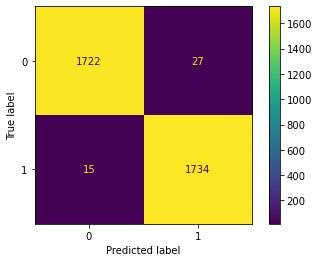

In [46]:
metrics.ConfusionMatrixDisplay.from_predictions(Y_train, y_train_tfidf_predict)

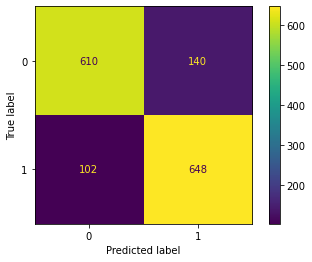

In [47]:
metrics.ConfusionMatrixDisplay.from_predictions(Y_test, y_test_tfidf_predict)

In [48]:
if len(bow_clf.classes_) == 2:
    print('Precision:', metrics.precision_score(Y_train, y_train_tfidf_predict, pos_label = 1))
    print('Recall:', metrics.recall_score(Y_train, y_train_tfidf_predict, pos_label = 1))
    print('F1:', metrics.f1_score(Y_train, y_train_tfidf_predict, pos_label = 1))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', metrics.precision_score(Y_train, y_train_tfidf_predict, average = None))
    print('Recall:', metrics.recall_score(Y_train, y_train_tfidf_predict, average = None))
    print('F1:', metrics.f1_score(Y_train, y_train_tfidf_predict, average = None))

Precision: 0.9846678023850085
Recall: 0.9914236706689536
F1: 0.9880341880341881


In [49]:
if len(tfidf_clf.classes_) == 2:
    print('Precision:', metrics.precision_score(Y_test, y_test_tfidf_predict, pos_label = 1))
    print('Recall:', metrics.recall_score(Y_test, y_test_tfidf_predict, pos_label = 1))
    print('F1:', metrics.f1_score(Y_test, y_test_tfidf_predict, pos_label = 1))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', metrics.precision_score(Y_test, y_test_tfidf_predict, average = None))
    print('Recall:', metrics.recall_score(Y_test, y_test_tfidf_predict, average = None))
    print('F1:', metrics.f1_score(Y_test, y_test_tfidf_predict, average = None))

Precision: 0.8223350253807107
Recall: 0.864
F1: 0.8426527958387517


#### Análisis del error

In [50]:
error_df = pd.concat([
    pd.concat([X_test, Y_test], axis = 1).reset_index(),
    pd.Series(y_test_tfidf_predict)
], axis = 1).rename(columns = { 'sentimiento': 'actual', 0: 'predicted' })

error_df.drop('index', inplace = True, axis = 1)

In [51]:
error_df.loc[error_df['actual'] != error_df['predicted']].shape

(242, 3)

In [52]:
error_df.loc[error_df['actual'] != error_df['predicted']].sample(10)

,review_es,actual,predicted
211,deep sea 3d es una impresionante visión en un ...,0,1
495,cuando las chicas gilmore comenzaron en aleman...,1,0
1230,realmente esperaba ver a nana después de ver e...,0,1
907,la policía de dominion tank está sin cáscara d...,1,0
624,no podía esperar para poner esta película en m...,0,1
965,lifeforce es una película extremadamente esqui...,1,0
737,bueno es un monograma rápido desde el temido p...,0,1
1402,y yo por un caso eso es algo bueno nunca he si...,1,0
867,me encantó tanto la última película de bellocc...,0,1
1332,why would burt lancaster allow himself to play...,0,1


### 1.3.2 Modelo con Regresión logistica

In [53]:

bow_model=LogisticRegression(random_state=2)

In [54]:
bow_model.fit(X_bow, Y_train)

LogisticRegression(random_state=2)

In [57]:
y_train_bow_predict = bow_model.predict(X_bow)
y_test_bow_predict = bow_model.predict(bow.transform(X_test))

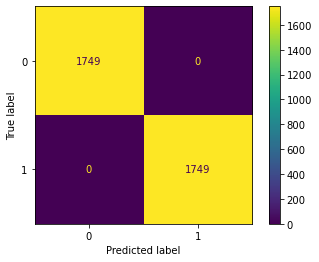

In [58]:
from sklearn.metrics import ConfusionMatrixDisplay


ConfusionMatrixDisplay.from_predictions(Y_train, y_train_bow_predict)

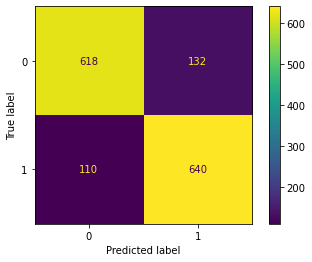

In [60]:
ConfusionMatrixDisplay.from_predictions( Y_test,y_test_bow_predict)

In [62]:
from sklearn.metrics import f1_score, precision_score, recall_score


if len(bow_model.classes_) == 2:
    print('Precision:', precision_score(Y_train, y_train_bow_predict, pos_label = 1))
    print('Recall:', recall_score(Y_train, y_train_bow_predict, pos_label = 1))
    print('F1:', f1_score(Y_train, y_train_bow_predict, pos_label = 1))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(Y_train, y_train_bow_predict, average = None))
    print('Recall:', recall_score(Y_train, y_train_bow_predict, average = None))
    print('F1:', f1_score(Y_train, y_train_bow_predict, average = None))

Precision: 1.0
Recall: 1.0
F1: 1.0


In [63]:
if len(bow_model.classes_) == 2:
    print('Precision:', precision_score(Y_test, y_test_bow_predict, pos_label = 1))
    print('Recall:', recall_score(Y_test, y_test_bow_predict, pos_label = 1))
    print('F1:', f1_score(Y_test, y_test_bow_predict, pos_label = 1))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(Y_test, y_test_bow_predict, average = None))
    print('Recall:', recall_score(Y_test, y_test_bow_predict, average = None))
    print('F1:', f1_score(Y_test, y_test_bow_predict, average = None))

Precision: 0.8290155440414507
Recall: 0.8533333333333334
F1: 0.8409986859395532


### 1.3.2.2 Modelo usando TF-IDF

In [64]:
tfidf_model = LogisticRegression(random_state = 3)

In [65]:
tfidf_model.fit(X_tfidf, Y_train)

LogisticRegression(random_state=3)

In [66]:
y_train_tfidf_predict = tfidf_model.predict(X_tfidf)
y_test_tfidf_predict = tfidf_model.predict(tfidf.transform(X_test))

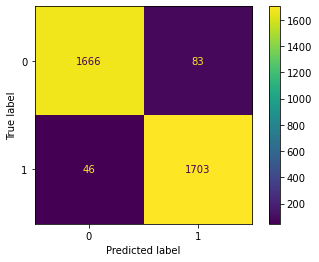

In [67]:
ConfusionMatrixDisplay.from_predictions(Y_train, y_train_tfidf_predict)

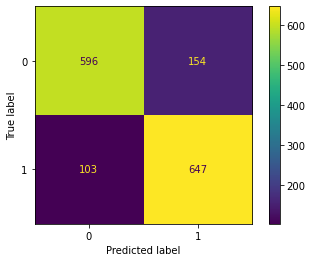

In [68]:
ConfusionMatrixDisplay.from_predictions(Y_test, y_test_tfidf_predict)

In [69]:
if len(bow_model.classes_) == 2:
    print('Precision:', precision_score(Y_train, y_train_tfidf_predict, pos_label = 1))
    print('Recall:', recall_score(Y_train, y_train_tfidf_predict, pos_label = 1))
    print('F1:', f1_score(Y_train, y_train_tfidf_predict, pos_label = 1))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(Y_train, y_train_tfidf_predict, average = None))
    print('Recall:', recall_score(Y_train, y_train_tfidf_predict, average = None))
    print('F1:', f1_score(Y_train, y_train_tfidf_predict, average = None))

Precision: 0.9535274356103024
Recall: 0.9736992567181246
F1: 0.9635077793493635


In [70]:
if len(tfidf_model.classes_) == 2:
    print('Precision:', precision_score(Y_test, y_test_tfidf_predict, pos_label = 1))
    print('Recall:', recall_score(Y_test, y_test_tfidf_predict, pos_label = 1))
    print('F1:', f1_score(Y_test, y_test_tfidf_predict, pos_label = 1))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(Y_test, y_test_tfidf_predict, average = None))
    print('Recall:', recall_score(Y_test, y_test_tfidf_predict, average = None))
    print('F1:', f1_score(Y_test, y_test_tfidf_predict, average = None))

Precision: 0.8077403245942572
Recall: 0.8626666666666667
F1: 0.8343004513217279


### 1.3.2.3 Análisis del error

In [72]:
error_df = pd.concat([
    pd.concat([X_test, Y_test], axis = 1).reset_index(),
    pd.Series(y_test_tfidf_predict)
], axis = 1).rename(columns = { 'sentimiento': 'actual', 0: 'predicted' })

error_df.drop('index', inplace = True, axis = 1)

In [73]:
error_df.loc[error_df['actual'] != error_df['predicted']].shape

(257, 3)

In [74]:
error_df.loc[error_df['actual'] != error_df['predicted']].sample(10)

,review_es,actual,predicted
287,seguimiento del precio de vincent a la casa de...,1,0
468,por los derechos nunca debería haber habido un...,0,1
828,imagina una isla de gilligan en el desierto af...,0,1
1155,los disfraces son escandalosos y el paisaje de...,0,1
390,en general estoy de acuerdo totalmente con la ...,1,0
1328,este trabajo es bastante atmosférico con un pa...,1,0
604,este es definitivamente uno de los mejores clá...,1,0
510,no podría relacionarme con esta película no se...,0,1
1317,la extrañamente llamada vera ellen fue bailar ...,0,1
1099,kevin kline y meg ryan están entre la clase de...,0,1


### 1.3.2.4 Selección del modelo


In [105]:

pipeline = Pipeline(steps = [
    ('vectorizer', CountVectorizer(tokenizer = tokenizer, stop_words = stopwords_spanish, lowercase = True)),
    ('classifier', LogisticRegression(random_state = 3))
])

In [106]:
param_grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'vectorizer__stop_words': [stopwords_spanish, None],
    'vectorizer__tokenizer': [tokenizer],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__max_iter': [100, 500, 1000]
}

In [107]:
from sklearn.model_selection import GridSearchCV



search = GridSearchCV(pipeline, param_grid, scoring = ['precision', 'recall', 'f1'], refit = 'f1', cv = 10, return_train_score = True, verbose = 1)

In [108]:
LogisticRegression().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [109]:
search.fit(X_train, Y_train)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


In [ ]:
search.best_params_

In [ ]:
search.best_score_

In [ ]:
y_test_search_predict = search.best_estimator_.predict(X_test)

In [ ]:
print('Precision:', precision_score(Y_test, y_test_search_predict))
print('Recall:', recall_score(Y_test, y_test_search_predict))
print('F1:', f1_score(Y_test, y_test_search_predict))

## 1.4 Resultados


## 1.5 Trabajo en equipo